<a href="https://colab.research.google.com/github/Pavalya-Periyasamy05/Machine-Learning-and-AI/blob/main/ML_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Word : Documnets/AIRandom Forest classi/
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
# 1. DATA ACQUISITION
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/splice-junction-gene-sequences/splice.data"
columns = ['Class', 'Instance_Name', 'Sequence']
df = pd.read_csv(url, names=columns, skipinitialspace=True) # removes space after comma between columns
df

,Class,Instance_Name,Sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...
...,...,...,...
3185,N,ORAHBPSBD-NEG-2881,TCTCTTCCCTTCCCCTCTCTCTTTCTTTCTTTTCTCTCCTCTTCTC...
3186,N,ORAINVOL-NEG-2161,GAGCTCCCAGAGCAGCAAGAGGGCCAGCTGAAGCACCTGGAGAAGC...
3187,N,ORARGIT-NEG-241,TCTCGGGGGCGGCCGGCGCGGCGGGGAGCGGTCCCCGGCCGCGGCC...
3188,N,TARHBB-NEG-541,ATTCTACTTAGTAAACATAATTTCTTGTGCTAGATAACCAAATTAA...


In [4]:
# 2. FEATURE ENGINEERING
# Converting the 60-character string into 60 individual columns bz machine learning can not handle strings of letters like sequence
X_raw = df['Sequence'].str.strip().apply(list).tolist() # convert series of strings to series of lists (pandas) and then to python lists
X_columns = [f'Pos_{i}' for i in range(1, 61)] # given column names
X_df = pd.DataFrame(X_raw, columns=X_columns)
X_df
# To list out the unique values of each column
#for col in X_df.columns:
    #print(col, X_df[col].unique())
# Found N and D, not part of nucleotides
X_df = X_df.replace({'D': 'N'}) # Replaced D to N
#X_df = X_df[~X_df.isin(['N']).any(axis=1)] # did earlier but to match with y variable and X variable rows we need a diff code
mask = ~X_df.isin(['N']).any(axis=1)
# Filter X_df and y simultaneously
X_df_filtered = X_df[mask]
y_filtered = df['Class'][mask]
#Resetting the index makes the rows consecutive starting from 0: since we deleted some rows
X_df_filtered = X_df_filtered.reset_index(drop=True) # drops the old index, by default it keeps old
y_filtered = y_filtered.reset_index(drop=True)


#X_df.isin(['N'])      → Creates a boolean DataFrame: True where the value is 'N', False otherwise
#.any(axis=1)           → Checks each row: True if **any** column in that row is 'N', False if none
#~                      → Negates the boolean: True becomes False, False becomes True
#X_df[~X_df.isin(['N']).any(axis=1)]  → Keeps only the rows that **do not contain any 'N'** (all False rows)
print(X_df_filtered.shape) # → original categorical columns (Pos_1 … Pos_60) without 'N'.
print(y_filtered.shape)



(3177, 60)
(3177,)


In [5]:
## EXPLICIT INDEPENDENT VARIABLE  ENCODING (X)
# One-Hot Encoding the DNA bases (A, C, G, T)
#OneHotEncoder converts categorical values (labels / categories) into binary (0/1) vectors.

encoder = OneHotEncoder(sparse_output=False) # include both 1 and 0
X_encoded = encoder.fit_transform(X_df_filtered)
#fit(): Learns the categories from your data (A, C, G, T for each column) Each nucleotide → 4 binary features (60*4=240 features)
#transform(): Converts your data to one-hot encoded vectors using the learned categories, uses float numbers by default

feature_names = encoder.get_feature_names_out(X_df_filtered.columns) #get_feature_names_out() function of OneHotEncoder
feature_names
#Without X_df_filtered.columns → generic names (x0_A, x1_T, …)
#With X_df_filtered.columns → descriptive names (Pos_1_A, Pos_2_T, …)

X_encoded_df = pd.DataFrame(X_encoded, columns=feature_names)
X_encoded_df.head()

# List col names in a DataFrame
# Method 1: Using .columns attribute
print(X_encoded_df.columns)
# or
list(X_encoded_df.columns)
# or
# Method 2: Using .columns.tolist()
X_encoded_df.columns.tolist()

      # Dependent Variable/ Target : Y


# To list out unique class names in a dataframe
unique_classes = df["Class"].unique() # Gives u array  array(['EI', 'IE', 'N'], dtype=object)
unique_classes

unique_classes_list = df['Class'].unique().tolist() # python list ['EI', 'IE', 'N']
print(unique_classes_list)


# EXPLICIT TARGET ENCODING (y)
# This converts ['EI', 'IE', 'N'] into [0, 1, 2]
label_enc = LabelEncoder()
Y_encoded = label_enc.fit_transform(y_filtered)

# Store the mapping so you can "decode" results later
# 0 = EI, 1 = IE, 2 = N (usually alphabetical)
class_names = label_enc.classes_
#| Part      | Meaning                           |
#| --------- | --------------------------------- |
#| `classes` | Multiple class labels (EI, IE, N) |
#| `_`       | Learned from data during `fit()`  |

print(f"Class Mapping: {dict(zip(range(len(class_names)), class_names))}")
# | **Step** | **Code / Concept**                          | **What it Produces**                   | **Intuitive Meaning (In Simple Words)**                               |
#| -------- | ------------------------------------------- | -------------------------------------- | --------------------------------------------------------------------- |
#| **1**    | `class_names = label_enc.classes_`          | `['EI', 'IE', 'N']`                    | These are the **original class labels** in your dataset (target `y`). |
#| **2**    | `len(class_names)`                          | `3`                                    | Total number of unique classes = **3**                                |
#| **3**    | `range(len(class_names))`                   | `0, 1, 2`                              | These are the **numeric labels** the model uses internally.           |
#| **4**    | `zip(range(len(class_names)), class_names)` | `(0,'EI'), (1,'IE'), (2,'N')`          | Pairs each **number** with its **actual class name**.                 |
#| **5**    | `dict(zip(...))`                            | `{0:'EI', 1:'IE', 2:'N'}`              | Creates a **mapping dictionary** from number → class.                 |
#| **6**    | `print(f"Class Mapping: {...}")`            | `Class Mapping: {0:'EI',1:'IE',2:'N'}` | Displays the mapping in a readable format.                            |




# Now we have got dependent variable (y_encoded) and independent variable (X_encoded_df)
print(X_encoded_df.shape) # one-hot encoded numeric version ready for ML.
print(Y_encoded.shape)

#Key points
# Mask ensures rows with 'N' are removed consistently for both X and y.

# Reset index after filtering to avoid misalignment.

# One-hot encoding produces numeric ML-ready data.

# Label encoding converts categorical target into numeric labels.

# Shapes confirm everything matches.



Index(['Pos_1_A', 'Pos_1_C', 'Pos_1_G', 'Pos_1_T', 'Pos_2_A', 'Pos_2_C',
       'Pos_2_G', 'Pos_2_T', 'Pos_3_A', 'Pos_3_C',
       ...
       'Pos_58_G', 'Pos_58_T', 'Pos_59_A', 'Pos_59_C', 'Pos_59_G', 'Pos_59_T',
       'Pos_60_A', 'Pos_60_C', 'Pos_60_G', 'Pos_60_T'],
      dtype='object', length=242)
['EI', 'IE', 'N']
Class Mapping: {0: 'EI', 1: 'IE', 2: 'N'}
(3177, 242)
(3177,)


## **Without Splitting the data**

### Build a Random Forest Classifier Model

In [6]:
clf = RandomForestClassifier()

In [7]:
clf.fit(X_encoded_df, Y_encoded)

RandomForestClassifier()

### Feature Importance

In [8]:
#print(clf.feature_importances_)
# Highest number has got highest importance and the value numbers are in order to the respective input feature.

importance_df = pd.DataFrame({
    'Feature': X_encoded_df.columns,
    'Importance': clf.feature_importances_
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(15)
#Certain nucleotides at specific positions (around positions 28–35) are extremely important for predicting splice sites (EI / IE / N).
# When position 30 is G, the Random Forest strongly uses this information to classify the sequence.


,Feature,Importance
118,Pos_30_G,0.085022
127,Pos_32_T,0.072799
112,Pos_29_A,0.069061
122,Pos_31_G,0.061193
138,Pos_35_G,0.044976
109,Pos_28_C,0.027277
132,Pos_34_A,0.025373
116,Pos_30_A,0.015362
117,Pos_30_C,0.015171
119,Pos_30_T,0.014908


In [9]:
# Position-level importance
importance_df['Position'] = importance_df['Feature'].str.extract(r'(Pos_\d+)')

position_importance = (
    importance_df
    .groupby('Position')['Importance']
    .sum()
    .sort_values(ascending=False)
)

position_importance.head(10)


,Importance
Position,
Pos_30,0.130463
Pos_29,0.103104
Pos_32,0.102157
Pos_31,0.091725
Pos_35,0.061766
Pos_28,0.056028
Pos_34,0.035215
Pos_33,0.027479
Pos_25,0.020094


### Perform Prediction on single sample from the dataset

In [13]:
X_encoded_df
X_encoded_df.shape
# Used the first nucleotide sequence / First row
X_encoded_df.iloc[[0]].shape  # prints sklearn expected 2D format ((n_samples (1), n_features(242)))
X_encoded_df.iloc[[0]]

,Pos_1_A,Pos_1_C,Pos_1_G,Pos_1_T,Pos_2_A,Pos_2_C,Pos_2_G,Pos_2_T,Pos_3_A,Pos_3_C,...,Pos_58_G,Pos_58_T,Pos_59_A,Pos_59_C,Pos_59_G,Pos_59_T,Pos_60_A,Pos_60_C,Pos_60_G,Pos_60_T
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [11]:
print(clf.predict(X_encoded_df.iloc[[0]]))  # sklearn expects in 2D format(n_samples (1), n_features(242))

[0]


In [14]:
# Look at the probability of prediction, before it arrives at the conclusion
print(clf.predict_proba(X_encoded_df.iloc[[0]])) # .predict_proba always returns (n_samples,n_classes) in numpyarray format.

[[0.81 0.15 0.04]]


In [18]:
# To get the names of the classes instead as 0, 1 and 2
#Use LabelEncoder.classes_ after prediction to convert numbers to readable class names. Done in previous cell stored in a variable class_names
Y_pred_numeric = clf.predict(X_encoded_df.iloc[[0]]) # predict function expects in 2D format
Y_pred_label = class_names[Y_pred_numeric]
Y_pred_label

array(['EI'], dtype=object)

## **Data split (80/20 ratio)**

In [20]:
# 3. TRAIN-TEST SPLIT
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded_df, Y_encoded, test_size=0.2, random_state=42) #The order of variables is important to ensure correct assignment, and 0.2 specifies that 20% of the data will be used for the test set.

In [21]:
X_train.shape, Y_train.shape

((2541, 242), (2541,))

In [22]:
X_test.shape, Y_test.shape

((636, 242), (636,))

### Rebuild Random Forest Classifier Model

In [24]:
clf.fit(X_train, Y_train)

RandomForestClassifier()

### Perform Prediction on single sample from the train dataset

In [25]:
clf.predict(X_train.iloc[[0]])

array([2])

In [26]:
# Probability of the prediction
clf.predict_proba(X_train.iloc[[0]])

array([[0.  , 0.01, 0.99]])

### Perform Prediction on all samples of Test dataset

### Predicted labels

In [27]:
clf.predict(X_test)

array([1, 1, 1, 0, 1, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2,
       0, 0, 2, 0, 1, 2, 1, 2, 1, 2, 0, 0, 1, 2, 0, 0, 1, 2, 2, 2, 2, 2,
       0, 1, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 1, 0, 1, 0, 0, 2, 2, 2, 0, 0,
       2, 1, 2, 0, 2, 2, 2, 0, 2, 0, 1, 1, 2, 2, 2, 0, 1, 2, 0, 0, 2, 2,
       2, 0, 2, 2, 0, 1, 1, 2, 0, 2, 2, 2, 1, 0, 2, 2, 2, 0, 0, 2, 1, 2,
       0, 0, 2, 2, 0, 0, 1, 2, 1, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 1,
       2, 1, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 2, 0, 2, 2,
       1, 0, 0, 2, 2, 0, 1, 1, 2, 2, 2, 1, 1, 0, 2, 2, 1, 0, 1, 0, 2, 2,
       0, 2, 1, 0, 0, 1, 1, 0, 2, 0, 0, 1, 0, 0, 1, 0, 2, 2, 0, 0, 0, 1,
       2, 0, 0, 2, 2, 0, 2, 1, 2, 2, 0, 2, 2, 2, 1, 2, 1, 0, 2, 0, 1, 2,
       0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 0, 1, 2, 1, 0, 0, 2, 0, 0, 2, 2,
       2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 0, 0, 2, 1, 2, 1, 2, 1, 0, 2, 2, 2,
       0, 2, 2, 0, 0, 1, 1, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 0, 2, 2,
       2, 2, 2, 1, 2, 1, 0, 0, 2, 0, 0, 2, 2, 2, 2,

### Actual labels

In [32]:
# actual class labels
print(Y_test)

[1 1 1 0 1 0 0 2 0 2 2 2 0 2 2 2 2 2 0 0 2 2 0 0 2 0 1 2 1 2 1 2 0 0 1 2 0
 0 1 2 2 2 2 2 0 1 2 2 0 1 2 1 2 2 2 2 1 0 2 0 0 2 2 2 0 2 2 1 2 0 2 2 2 0
 2 0 1 1 2 2 2 0 2 2 0 0 2 2 2 0 2 2 0 0 1 2 0 2 2 2 2 0 2 2 2 0 0 2 1 2 0
 0 2 2 0 0 1 2 1 0 2 0 2 2 2 0 2 2 0 2 2 1 2 1 1 2 2 2 1 0 0 0 0 0 0 1 2 1
 2 1 2 0 2 2 1 0 0 2 2 0 1 1 2 2 2 1 1 0 2 2 1 0 2 0 2 2 0 2 1 0 0 1 1 0 2
 0 0 1 0 0 1 0 2 2 0 0 0 1 2 0 0 2 2 1 2 1 2 2 0 2 2 2 1 2 1 1 2 0 1 2 0 0
 0 1 2 0 0 2 2 2 2 0 2 2 1 0 0 2 0 0 2 2 2 1 2 1 1 1 1 2 2 2 0 0 2 1 2 1 2
 1 0 2 2 2 0 2 2 0 0 1 1 2 0 2 2 2 2 1 2 2 1 0 1 0 2 2 2 2 2 1 2 1 0 0 2 0
 0 2 2 2 2 2 2 1 2 2 0 2 2 0 1 1 2 2 0 0 2 0 2 0 2 0 2 2 1 2 2 2 2 1 2 2 0
 2 1 2 2 2 2 2 1 0 2 1 1 0 1 2 2 0 2 0 2 2 2 2 2 2 0 2 1 0 0 2 1 0 2 0 2 1
 2 2 2 2 1 2 2 2 0 0 1 2 1 1 1 1 2 2 0 1 2 2 2 0 1 2 0 2 0 1 2 0 1 2 2 1 2
 1 2 0 1 1 1 0 2 2 2 1 2 1 2 1 2 1 2 2 0 1 0 0 1 2 2 2 1 1 2 0 1 1 1 1 0 2
 2 2 2 2 0 0 2 1 2 0 0 2 2 1 1 2 1 1 1 2 1 1 2 0 2 1 2 2 0 2 0 0 2 1 0 2 2
 1 0 1 2 1 0 2 0 2 0 0 0 

### Mapping integer class labels back to their original class names

In [29]:
# For labels
X_test_pred_integer = clf.predict(X_test)
X_test_pred_labels = class_names[X_test_pred]
X_test_pred_labels

array(['IE', 'IE', 'IE', 'EI', 'IE', 'EI', 'EI', 'N', 'EI', 'N', 'N', 'N',
       'EI', 'N', 'N', 'N', 'N', 'N', 'EI', 'EI', 'N', 'N', 'EI', 'EI',
       'N', 'EI', 'IE', 'N', 'IE', 'N', 'IE', 'N', 'EI', 'EI', 'IE', 'N',
       'EI', 'EI', 'IE', 'N', 'N', 'N', 'N', 'N', 'EI', 'IE', 'N', 'N',
       'EI', 'N', 'N', 'IE', 'N', 'N', 'N', 'N', 'IE', 'EI', 'IE', 'EI',
       'EI', 'N', 'N', 'N', 'EI', 'EI', 'N', 'IE', 'N', 'EI', 'N', 'N',
       'N', 'EI', 'N', 'EI', 'IE', 'IE', 'N', 'N', 'N', 'EI', 'IE', 'N',
       'EI', 'EI', 'N', 'N', 'N', 'EI', 'N', 'N', 'EI', 'IE', 'IE', 'N',
       'EI', 'N', 'N', 'N', 'IE', 'EI', 'N', 'N', 'N', 'EI', 'EI', 'N',
       'IE', 'N', 'EI', 'EI', 'N', 'N', 'EI', 'EI', 'IE', 'N', 'IE', 'EI',
       'N', 'EI', 'N', 'N', 'N', 'EI', 'N', 'N', 'EI', 'N', 'N', 'IE',
       'N', 'IE', 'IE', 'N', 'N', 'N', 'IE', 'EI', 'EI', 'EI', 'EI', 'EI',
       'EI', 'IE', 'N', 'N', 'N', 'IE', 'N', 'EI', 'N', 'N', 'IE', 'EI',
       'EI', 'N', 'N', 'EI', 'IE', 'IE', 'N', 'N',

### Model Performance

In [33]:
print(clf.score(X_test,Y_test))

0.9685534591194969


In [ ]:
# 4. HYPERPARAMETER TUNING (The Engineering Step)
# Instead of picking numbers, we let the computer find the best ones
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

In [ ]:
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

In [ ]:
# 5. EVALUATION
y_pred = best_model.predict(X_test)
print(f"Best Parameters: {grid_search.best_params_}")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

--- Classification Report ---
              precision    recall  f1-score   support

          EI       0.98      0.96      0.97       179
          IE       0.92      0.95      0.94       140
           N       0.97      0.97      0.97       319

    accuracy                           0.96       638
   macro avg       0.96      0.96      0.96       638
weighted avg       0.96      0.96      0.96       638



In [ ]:
import pandas as pd
import numpy as np
import urllib.request
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. DATA ACQUISITION & RAW LOADING
# Using the direct URL to the .data file to automate the download
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/splice-junction-gene-sequences/splice.data"
columns = ['Class', 'Instance_Name', 'Sequence']
df = pd.read_csv(url, names=columns, skipinitialspace=True)

# 2. BIOINFORMATICS FEATURE ENGINEERING
# We split the 60-character DNA string into 60 separate categorical features
X_raw = df['Sequence'].str.strip().apply(list).tolist()
X_df = pd.DataFrame(X_raw, columns=[f'Pos_{i}' for i in range(1, 61)])

# DNA bases (A, C, G, T) must be numerically encoded for Scikit-Learn
# Handle non-standard bases (D, N, S, R) by using 'handle_unknown'
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X_df)
y = df['Class']

# 3. ROBUST EVALUATION STRATEGY
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 4. ENGINEERING OPTIMIZATION (Hyperparameter Tuning)
# Demonstrating that you can optimize a model's architecture
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 5. MODEL VALIDATION
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(best_model.classes_)
# Output: array(['EI', 'IE', 'N'], dtype=object)
print(f"Optimized Parameters: {grid_search.best_params_}")
print("\nDetailed Performance Analysis:")
print(classification_report(y_test, y_pred))

['EI' 'IE' 'N']
Optimized Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Detailed Performance Analysis:
              precision    recall  f1-score   support

          EI       0.99      0.96      0.97       179
          IE       0.93      0.95      0.94       140
           N       0.97      0.97      0.97       319

    accuracy                           0.97       638
   macro avg       0.96      0.96      0.96       638
weighted avg       0.97      0.97      0.97       638



Feature importance plot generated successfully.


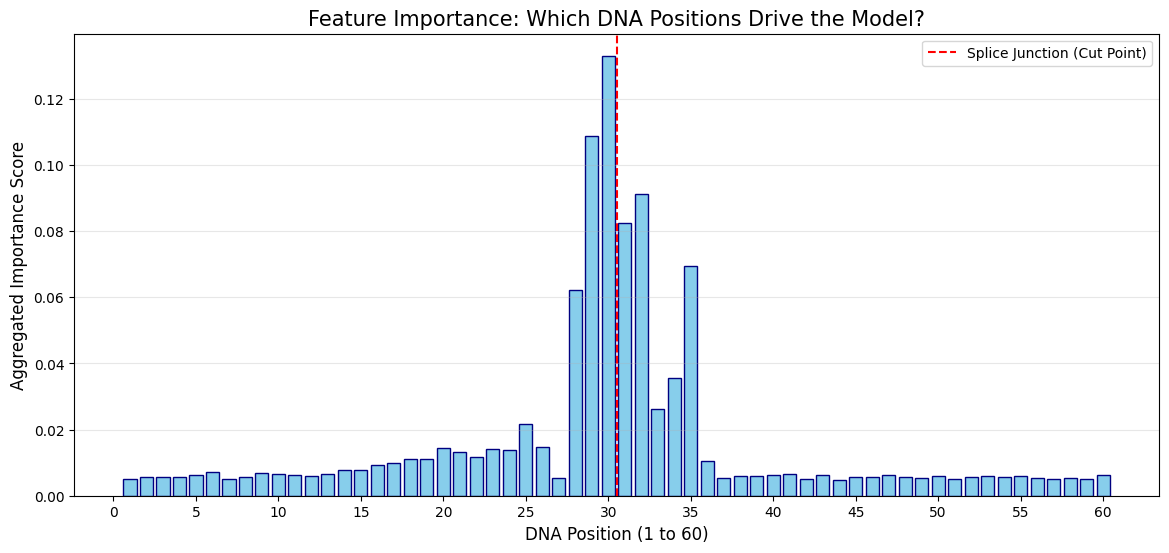

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Extract importances from your trained 'best_model'
# (Assuming you ran the pipeline code from the previous step)
importances = best_model.feature_importances_
feature_names = encoder.get_feature_names_out()

# 2. Aggregate importance by DNA position (1 to 60)
# Since One-Hot Encoding created 4 columns per position (A, C, G, T)
pos_importances = {}
for name, imp in zip(feature_names, importances):
    pos = name.split('_')[1] # Extracts '1' from 'Pos_1'
    pos_importances[pos] = pos_importances.get(pos, 0) + imp

# Sort values to ensure position 1 is first and 60 is last
sorted_positions = sorted(pos_importances.keys(), key=lambda x: int(x))
values = [pos_importances[p] for p in sorted_positions]

# 3. Create the Visualization
plt.figure(figsize=(14, 6))
plt.bar(range(1, 61), values, color='skyblue', edgecolor='navy')
plt.axvline(x=30.5, color='red', linestyle='--', label='Splice Junction (Cut Point)')

plt.title('Feature Importance: Which DNA Positions Drive the Model?', fontsize=15)
plt.xlabel('DNA Position (1 to 60)', fontsize=12)
plt.ylabel('Aggregated Importance Score', fontsize=12)
plt.xticks(np.arange(0, 61, 5))
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.savefig('dna_feature_importance.png')
print("Feature importance plot generated successfully.")